# Inverting for the Source

The method uses observed data (processed according to FieldDataProcessing.ipynb)
and synthetic data (from SPECFEM3D) and applies a simple linear inversion formula:

\begin{equation}
S(\omega)^{*} = \frac{u^{t}d^{*}}{u^{t}u^{*}}
\end{equation}

where u is the simulated wavefield and d is the observed wavefield.

/home/jiazeh/Desktop/my_files/py2project/venv/lib/python2.7/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


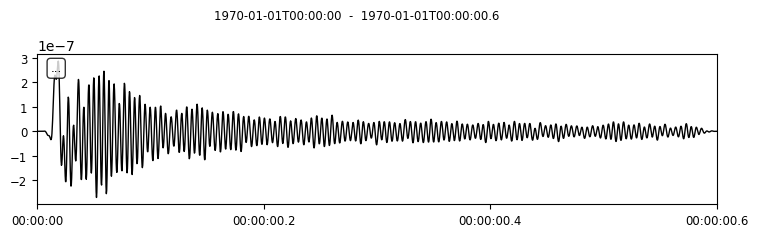

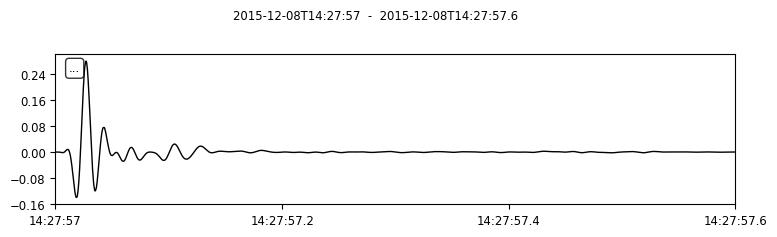

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime

# First we read in the observed and synthetic data and plot a single trace
field_obs = read('observed', unpacked_headers=True) # processed field data (720 traces)
specfem3d_syn = read('synthetic', unpacked_headers= True) # Green's function from SPECFEM3D (720 traces)
field_trace = field_obs.traces[4] # Trace about ~10 m away from source
syn_trace = specfem3d_syn.traces[4] # Trace about ~10 m away from source
beginTime = UTCDateTime(syn_trace.stats.starttime)
syn_trace.trim(beginTime, beginTime+0.6)
syn_trace.detrend('constant')
syn_trace.taper(max_percentage=0.05,type='cosine')
syn_trace.plot()
beginTime = UTCDateTime(field_trace.stats.starttime)
field_trace.trim(beginTime, beginTime+0.6)
field_trace.detrend('constant')
field_trace.taper(max_percentage=0.05,type='cosine')
field_trace.plot()

We now generate the frequency filter that has already been applied ot the processed field data. We plot the filter to verify.

('npts', 2001)
('nfft', 4004)
('freq_pos.shape - tukey', (101,))
('freq_pos.shape - pad', (109,))
('freq_pos.shape - resize', (2002,))
('freq_neg.shape - freq_pos[::-1]', (2002,))
('syn_taper.shape - append', (4004,))


Text(0,0.5,'Gain')

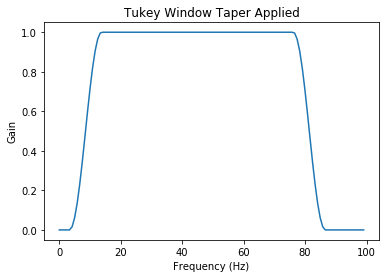

In [24]:
import numpy as np
from scipy import signal
from obspy.signal.util import _npts2nfft
from scipy.fftpack import fft, ifft, fftfreq

# Setup prefilter with cosine taper
npts = len(field_trace.data) # resampled trace so different from FieldDataProcessing
print('npts',npts)
nfft = _npts2nfft(npts)
print('nfft',nfft)
freq_pos = signal.tukey(101, alpha=0.25)
print('freq_pos.shape - tukey',freq_pos.shape)
freq_pos = np.pad(freq_pos, 4,'constant',constant_values=0)
print('freq_pos.shape - pad',freq_pos.shape)
freq_pos.resize(nfft/2)
print('freq_pos.shape - resize',freq_pos.shape)
freq_neg = freq_pos[::-1]
print('freq_neg.shape - freq_pos[::-1]',freq_neg.shape)
syn_taper = np.append(freq_pos, freq_neg)
print('syn_taper.shape - append',syn_taper.shape)
syn_taper
# Plot the filter
freqs = fftfreq(nfft, d=0.0003)
#freqs = fftfreq(nfft, d=0.000000003)
plt.plot(freqs[0:120],freq_pos[0:120])
plt.title('Tukey Window Taper Applied')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')

2001

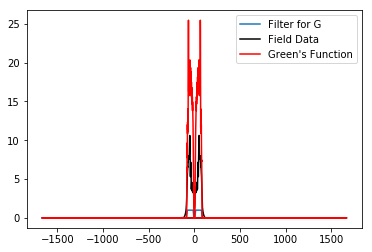

In [26]:
# Now we change into the frequency domain
syn_trace.data /= max(syn_trace.data)

fftsyn = fft(syn_trace.data, n=nfft)
fftfield = fft(field_trace.data, n=nfft)
fftsyn *= syn_taper

# Plot the spectrums
plt.plot(freqs,syn_taper)
plt.plot(freqs,np.abs(fftfield),color="black")
plt.plot(freqs,np.abs(fftsyn),color="red")
plt.legend(['Filter for G', 'Field Data', "Green's Function"])

In [29]:
# Now we invert for the source in the frequency domain 
stf = np.array([0.0+0.0j])
for i in range(1, nfft):
    if np.abs(fftsyn[i]) != 0:
        stf = np.append(stf, (fftsyn[i].T*fftfield[i].conj().T)/(fftsyn[i].T*fftsyn[i].conj().T))
    else:
        stf = np.append(stf, 0.0+0.0j)
stf = stf.conj().T

73


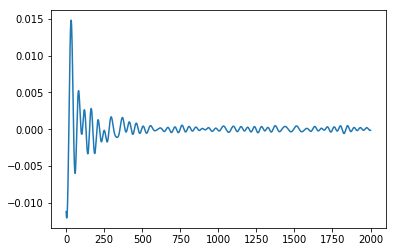

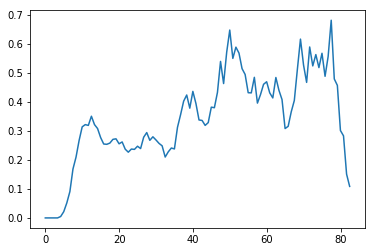

In [33]:
# Setup prefilter with cosine taper
#npts = len(syn_trace.data)
#nfft = _npts2nfft(npts)
freqindex = np.where(freqs>60)
print(freqindex[0][0])
freq_pos = signal.tukey(101, alpha=0.25)
freq_pos = np.pad(freq_pos, 4,'constant',constant_values=0)
freq_pos.resize(nfft/2)
#freq_pos = np.roll(freq_pos, 4)
freq_neg = freq_pos[::-1]
freq_taper = np.append(freq_pos, freq_neg)
# Plot the filter
freqs = fftfreq(nfft, d=0.0003)
# filter with cosine taper
stf *= freq_taper
#tf *= freq_taper
#stf *= syn_taper
plt.plot(ifft(stf,n=nfft)[0:npts])
plt.figure()
plt.plot(freqs[0:100], np.abs(stf[0:100]))
#plt.legend(['Taper Applied', 'STF after applying Taper'])

/home/jiazeh/Desktop/my_files/py2project/venv/lib/python2.7/site-packages/numpy/core/numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


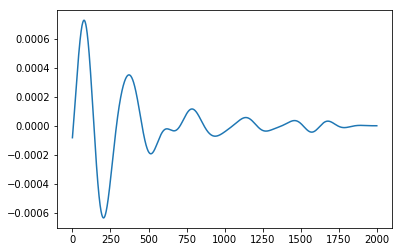

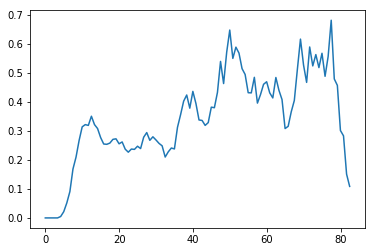

In [34]:
from obspy import Trace
st = Trace(data=ifft(stf,n=nfft)[0:npts])
st.stats.delta=0.0003
st.taper(max_percentage=0.05,type='hann')
st.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
plt.plot(st)
plt.figure()
plt.plot(freqs[0:100], np.abs(stf[0:100]))

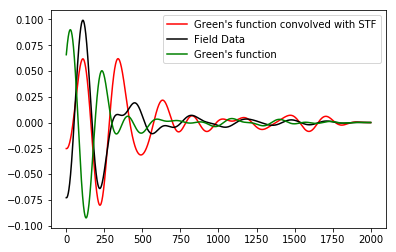

In [35]:
# Now convolve the source with the Green's Function
from obspy.core import Trace
from numpy.fft import *
#ik = np.array([2j*np.pi*k for k in xrange(0, nfft)])/ nfft
#fshift = np.exp(-ik*52)
syn_trace = specfem3d_syn.traces[4] # Trace about ~10 m away from source
beginTime = UTCDateTime(syn_trace.stats.starttime)
syn_trace.trim(beginTime, beginTime+0.6)
syn_trace.detrend('constant')
syn_trace.taper(max_percentage=0.05,type='cosine')
w = np.linalg.norm(syn_trace.data, ord=2)
syn_trace.data /= w
fftsyn = fft(syn_trace.data, n=nfft)
fftsyn *= syn_taper
#stf *= syn_taper
st = Trace(data=ifft(stf,n=nfft)[0:npts])
st.stats.delta=0.0003
st.detrend('demean')
st.taper(max_percentage=0.05,type='hann')
st.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
convolved_Green=ifft(fftsyn*fft(st.data,n=nfft), n=nfft)[0:npts]
synGreen = Trace(data=convolved_Green)
synGreen.stats.delta=0.0003
#plt.plot(ifft(stf,n=nfft)[0:npts])
synGreen.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
w = np.linalg.norm(synGreen.data, ord=2)
synGreen.data /= w
plt.plot(synGreen, color="red")
field_trace = field_obs.traces[4] # Trace about ~10 m away from source
field_trace.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
w = np.linalg.norm(field_trace.data, ord=2)
field_trace.data /= w
plt.plot(field_trace, color="black")
syn_trace.filter('bandpass',freqmin=8,freqmax=20,zerophase=True)
w = np.linalg.norm(syn_trace.data, ord=2)
syn_trace.data /= w
plt.plot(syn_trace,color="green")
plt.legend(["Green's function convolved with STF", "Field Data", "Green's function"])
plt.savefig('compare.pdf')

# Robust Source Inversion

This notebook improves the method described in SourceInversionSteps.ipynb by stacking
the results from the formula using different traces in a small radius from the source.

In [10]:
%matplotlib inline
import numpy as np
from obspy.core import Stream, Trace
from obspy.signal.util import _npts2nfft
from scipy import signal
from scipy.fftpack import fft, ifft, fftfreq
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime

# First we read in the observed and synthetic data
field_obs = read('processed_obsIR.su', unpacked_headers=True) # processed field data (720 traces)
specfem3d_syn = read('0_dz_SU', unpacked_headers= True) # Green's function from SPECFEM3D (720 traces)

IOError: [Errno 2] No such file or directory: 'processed_obsIR.su'

In [ ]:
allstf = np.zeros(1, dtype=np.complex)# Used to store the stacked stf
print(allstf.shape)
num_traces = 5 # number of traces used to estimate STF
#wshift = np.arange(0,0.0015,.0003) # shifting windows
    
for trace_index in range(0, num_traces): # Each trace is used to estimate STF 
    print(allstf.shape)

    field_trace = field_obs.traces[trace_index]
    syn_trace = specfem3d_syn.traces[trace_index]
    
    # Cut the window around the direct arrival
    beginTime = UTCDateTime(field_trace.stats.starttime)
    field_trace.trim(beginTime, beginTime+0.6)
    beginTime = UTCDateTime(syn_trace.stats.starttime)
    syn_trace.trim(beginTime, beginTime+0.6)

    field_trace.detrend('constant')
    field_trace.taper(max_percentage=0.05,type='cosine')

    syn_trace.detrend('constant')
    syn_trace.taper(max_percentage=0.05,type='cosine')
    # Now we change into the frequency domain
    if (trace_index == 0): # First trace
        npts = len(field_trace.data) # length of signal
        nfft = _npts2nfft(npts)
        allstf.resize(nfft)
    print(allstf.shape)

    syn_trace.normalize() # FIX! This should not be necessary
    fftsyn = fft(syn_trace.data, n=nfft)
    fftfield = fft(field_trace.data, n=nfft)
    freqs = fftfreq(len(fftfield), d=0.0003)

    # Setup prefilter with cosine taper
    freqindex = np.where(freqs>85)
    freq_pos = signal.tukey(101, alpha=0.25)
    freq_pos.resize(nfft/2)
    freq_neg = freq_pos[::-1]
    freq_taper = np.append(freq_pos, freq_neg)

    # Apply prefilter to synthetic (already applied to real data)
    fftsyn *= freq_taper
        
    # Now we invert for the source in the frequency domain 
    stf = np.array([0.0+0.0j])
    for i in range(1, nfft):
        if np.abs(fftsyn[i]) != 0:
            stf = np.append(stf, (fftsyn[i].T*fftfield[i].conj().T)/(fftsyn[i].T*fftsyn[i].conj().T))
        else:
            stf = np.append(stf, 0.0+0.0j)
    stf = stf.conj().T
    plt.plot(freqs[0:50], np.abs(stf[0:50]))
    stf *= freq_taper # filter the stf
    print(allstf.shape,stf.shape)
    allstf += stf # stack the stf
plt.legend(['trace 1', 'trace 2', 'trace 3', 'trace 4', 'trace 5'])
allstf /= num_traces # Normalize

In [9]:
# Now convolve the source with the Green's Function
from obspy.core import Trace
convolved_Green=ifft(fftsyn*allstf, n=nfft)[0:npts]
synGreen = Trace(data=convolved_Green)
synGreen.stats.delta=0.0003
plt.plot(synGreen.data, color="red")
plt.plot(ifft(fftfield, n=nfft)[0:npts], color="black")
plt.legend(["Green's function convolved with STF", "Field Data"])

NameError: name 'allstf' is not defined